<a href="https://colab.research.google.com/github/audrb1999/DL-Project/blob/main/3.%20R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R-CNN
 - R-CNN은 우선 CPU상에서 Selective Search를 진행합니다. 
 - 그러면 물체가 존재할법한 위치 2천개를 찾게 됩니다. 그 2천개의 이미지를 개별적으로 CNN 네트워크에 넣어서 feature vector을 추출합니다.
 - 이후 그러한 벡터들에 대해여 SVM을 이용해서 Classification을 진행하고 Regressors을 이용해서 정확한 바운딩 박스가 어딘지 예측할 수 있게 합니다.

> 여기서는 VGG-16에 넣어서 Classification까지 끝냈고 IoU를 통해서 바운딩 박스를 예측했습니다.



R-cnn의 4단계

1. 선택적 검색을 통해 이미지를 전달하고 지역 제안을 생성합니다.

2. 정답 데이터를 사용하여 제안된 영역에 대한 IOU(교집합)를 계산하고 제안된 영역에 레이블을 추가합니다.

3. 레이블이 있는 제안된 영역을 사용하여 전이 학습을 수행합니다.

4. 테스트 이미지를 선택적 검색에 전달한 다음 훈련된 모델에서 처음 2000개의 제안된 영역을 전달하고 해당 영역의 클래스를 예측합니다.

R-CNN은 Image classification을 수행하는 CNN과 localization을 위한 regional proposal알고리즘을 연결한 모델이다.

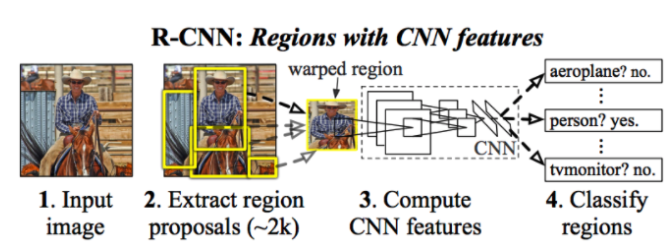



"R-CNN 프로세스"

1. Image를 입력받는다.

2. Selective search알고리즘에 의해 regional proposal output 약 2000개를 추출한다.

추출한 regional proposal output을 모두 동일 input size로 만들어주기 위해 warp해준다.



# 데이터 전처리 환경

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# R-CNN을 구현하는데 필요한 라이브러리
# 이미지에 대한 선택적 검색을 수행하려면 cv2(opencv-contrib-python)가 필요합니다.

import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/object detection/data')

In [ ]:
import zipfile
with zipfile.ZipFile('Images.zip') as data_zip:
    data_zip.extractall('./data')
with zipfile.ZipFile('Airplanes_Annotations.zip') as data_zip:
    data_zip.extractall('./annotation')

In [ ]:
images_dir = 'data/Images/'
label_dir = 'annotation/Airplanes_Annotations/'

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
# Selective Search로 찾은 박스에 레이블링하는 함수입니다.
# Selective Search를 초기화하고 다음번에 ss.setBaseImage(image) 이런 형태로 이미지를 받습니다.
# 이 알고리즘을 통해서 물체가 있을만한 박스 2천개를 추출합니다.

# 전처리

- IoU란?

IoU는 Intersection over Union의 약자로 보통 두 가지 물체의 위치(Bounding Box)가 얼마나 일치하는지를 수학적으로 나타내는 지표이다

$IoU= \frac {Intersection} {A+B−Intersection} $
​
 

In [ ]:
# 이 함수는 두 경계 상자 사이의 합집합에 대한 교차를 계산하는 역할을 합니다.

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']# x1은 왼쪽부분 x2는 오른쪽 부분일 경우가 아니면 오류
    assert bb1['y1'] < bb1['y2']# y1은 아래부분 y2는 윗부분
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # 교차 직사각형의 (x, y) 좌표를 설정합니다.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    
    # 공간이 겹치지 않으면 0 리턴
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # 겹친 공간
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # 박스 공간, 두 박스 크기를 구하고 겹치는 부분을 구해야 IoU를 구할 수 있음
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    
    #A∩B / A∪B
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou 
    # 0~1 사이 확률값일 경우 리턴

모델에 전달할 데이터 세트를 전처리하고 생성하는 코드

이 경우 2개의 클래스를 가질 수 있습니다

In [ ]:
 os.listdir(label_dir)[0]

'airplane_095.csv'

In [ ]:
len(os.listdir(label_dir))

733

In [ ]:
c = pd.read_csv(os.path.join(label_dir, os.listdir(label_dir)[0]))

In [ ]:
c.head()

,1
0,46 87 180 221


In [ ]:
for z in c.iterrows():
    print(z)
    print(z[1][0].split(' ')[0])

(0, 1    46 87 180 221
Name: 0, dtype: object)
46


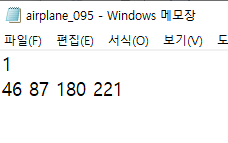

- 해당 레이블과 쌍을 이루는 이미지

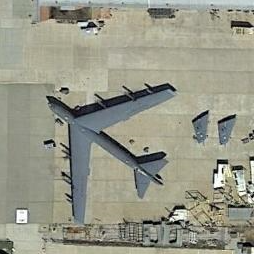

비행기 위치들 좌표 데이터 형태가 튜플로 존재

(0, 46 87 180 221)

여기서 두 번째 데이터를 선택해서 공백으로 스플릿을 진행, 그 후 첫 번째 원소만 가져옴

이것을 4번 반복해서 총 4군대의 비행기 좌표를 가져옴

사각형으로 표시되니까 4개의 숫자가 한 비행기를 가르키는 것

pandas의 DataFrame의 각 행을 반복적인 작업을 할 때는 iterrows 메서드를 호출하여 사용합니다.

In [ ]:
train_images = []
train_labels = []


for e, i in enumerate(os.listdir(label_dir)):# e = index, i = data
    # label 파일 리스트 이름 만큼 반복

    try:
        if i.startswith('airplane'):# 이름에 airplane을 포함한 파일만 True
            filename = i.split('.')[0]+ '.jpg'# 이미지 파일로 변경
            print(e, filename)# 인덱스, 이미지 파일 이름
            image = cv2.imread(os.path.join(images_dir, filename))# 경로상의 이미지 부르기
            df = pd.read_csv(os.path.join(label_dir, i))# 경로상의 csv파일 부르기
            gtvalues = []

            for row in df.iterrows():
                # 각각의 비행기를 표시하기 위한 좌표를 가져옴
                # 한 사진에 여러 데이터가 존재할 시 iterrows로 여러 번 반복함
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])

                # 각 데이터를 딕셔너리 형태로 저장
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            
            # 이미지에서 물체가 있을 만한 곳의 데이터를 2천개 받고 레이블링 진행
            ss.setBaseImage(image)# 함수가 클래스를 초기화하는 데 사용하는 이미지를 설정
            ss.switchToSelectiveSearchFast()# Selective search fast 매개변수로 클래스 초기화
            ssresults = ss.process()# 실행
            
            # 이미지를 저장하고
            imout = image.copy()

            
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0

            
            
            # 이미지 박스로 작업 시작
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:# 2000개 이전이거나 flag == 0일 때
                    for gtval in gtvalues:# 각 객체 좌표를 가져와서(정답)
                        x,y,w,h = result# 알고리즘이 예측한 좌표를 받고
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})# 알고리즘이 예측한 좌표의 겹침을 확인
                        if counter < 10: # 10 이하 일 때, 한 이미지에 10개가 넘는 객체가 존재하지 않게
                            if iou > 0.70: # iou 값이 0.7보다 크면 객체가 존재한다고 판다
                                timage = imout[y:y+h,x:x+w]# 이미지에서 객체가 있다고 예측한 곳을 잘라서
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)# 224로 바꾸고
                                train_images.append(resized)# 학습 이미지에 저장시킴
                                train_labels.append(1)# 레이블링 = 객체가 존재하면 1
                                counter += 1 # 카운터 진행, 

                        else : # 30개를 넘는 객체가 존재한다면
                            fflag =1 

                        if falsecounter <10:
                            if iou < 0.3: # 0.3보다 작으면 배경이라고 생각
                                timage = imout[y:y+h,x:x+w]# 예측한 배경을 잘라서
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)# 이미지 shape을 바꾸고
                                train_images.append(resized)# 학습 이미지에 저장
                                train_labels.append(0)# 레이블은 0
                                falsecounter += 1# 배경 카운터 진행
                        else :# 배경도 30개 이상 존재할 때
                            bflag = 1

                    if fflag == 1 and bflag == 1: # 배경과 객체가 30개 이상 존재할 때
                        print("inside")
                        flag = 1
                        
    except Exception as e:# 위에서 오류가 발생하면 해당 파일에 문제가 생겼다고 알림
        print(e)
        print("error in "+filename)
        continue

# 바운딩 박스가 쳐진 이미지들과 실제 객체 좌표를 IoU로 비교해서 배경 데이터와 객체 데이터를 나눔
# 이 때 음성(배경) 양성(객체) 데이터가 최대 10개 정도 설정되게 한 것

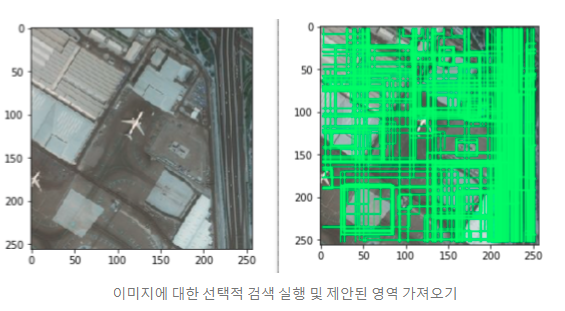

물체가 있을법한 곳에 전부 바운딩을 칩니다.

그리고 저 정보들을 IoU를 통해서 물체와 배경 데이터를 걸러내고 그 중에서 20개를 학습 데이터로 가져옵니다.

In [ ]:
# 모은 데이터를 넘파이로 바꿈
X_new = np.array(train_images)
y_new = np.array(train_labels)

# 모델링

In [ ]:
# 모델링할 때 필요한 라이브러리

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights='imagenet', include_top=True)# CNN부분은 Imagenet VGG를 사용하여 진행

클래스가 2개밖에 없어서 마지막 층 변경

In [ ]:
for layers in (vggmodel.layers)[:15]:# VGG의 레이어들을 확인
    print(layers)
    layers.trainable = False # 15개 고정

X= vggmodel.layers[-2].output# 마지막 2번째 fc(4096)을 받아서 소프트 맥스 이전층
predictions = Dense(2, activation="softmax")(X)# 2클래스 분류로 변경
model_final = Model(vggmodel.input, predictions)# 모델 구성
opt = Adam(lr=0.0001)# 최적화는 아담 0.0001
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])# 설정하고
model_final.summary()# 모델 구조

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

class MyLabelBinarizer(LabelBinarizer): # 데이터 세트를 원핫 인코딩
    def transform(self, y):# 2개 클래스가 존재할 때 벡터를 반환
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
            
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
# Data Augment를 간단하게 진행

trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

ModelCheckpoint로 

- 첫 번째 인자(filepath) = 모델 저장 경로

- monitor = 저장이 되는 기준(val_loss가 가장 작을 때)

- verbose 
 - 0일 때는 "저장되었습니다." 
 - 출력 1일 때는 표시없이 바로 모델 저장

- save_best_only = 
 - True는 monitor 되고 있는 값을 기준으로 가장 좋은 값이 저장
 - False는 매 에폭마다 모델이 filepath{epoch}로 저장됩니다.

- save_weights_only 
 - True = 모델 가중치만 저장
 - False = 모델 레이어 및 가중치 모두 저장

- mode
 - 'max' = val_acc인 경우 정확도가 클수록 좋으니 max
 - 'min' = val_loss인 경우 loss가 적을수록 좋으니 min
 - 'auto' = 모델이 알아서 min, max를 설정하고 저장합니다.

- period = 체크포인트 간격(세대의 수)


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 100, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 4s 435ms/step - loss: 0.3562 - accuracy: 0.8687 - val_loss: 0.2173 - val_accuracy: 0.9062

Epoch 00001: val_loss improved from inf to 0.21729, saving model to ieeercnn_vgg16_1.h5
Epoch 2/100
10/10 [==============================] - 4s 393ms/step - loss: 0.3919 - accuracy: 0.8625 - val_loss: 0.2728 - val_accuracy: 0.9062

Epoch 00002: val_loss did not improve from 0.21729
Epoch 3/100
10/10 [==============================] - 4s 395ms/step - loss: 0.2686 - accuracy: 0.9250 - val_loss: 0.3080 - val_accuracy: 0.8750

Epoch 00003: val_loss did not improve from 0.21729
Epoch 4/100
10/10 [==============================] - 4s 432ms/step - loss: 0.1874 - accuracy: 0.9500 - val_loss: 0.0993 - val_accuracy: 0.9531

Epoch 00004: val_loss improved from 0.21729 to 0.09935, saving model to ieeercnn_vgg16_1.h5
Epoch 5/100
10/10 [==============================] - 4s 397ms/step - loss: 0.3160 - accuracy: 0.8750 - val_loss: 0.1876 - val_accuracy: 0.9375

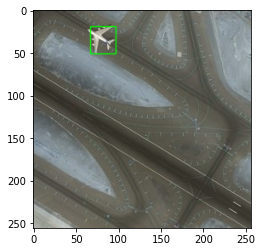

In [ ]:
z=0
for e,i in enumerate(os.listdir(images_dir)):# 이미지들을 받아서
    if i.startswith("4"):# 4라능 이름이 붙은 데이터만, test data
        z += 1# 실행이 되면 z를 카운팅해주고
        img = cv2.imread(os.path.join(images_dir,i))# 4가 있는 이미지를 받아서 
        
        # 바운딩 박스치면서 물체가 있을법한 정보를 전부 받아와서
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        break